In [25]:
import cv2
import numpy as np
from matplotlib import pyplot as plt
from statistics import mode

In [26]:
def analyze_sap_prototype(prototype_path, min_height=10, max_height=50, thresh_val=230):
    image = cv2.imread(prototype_path)
    if image is None:
        return None

    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
    _, thresh = cv2.threshold(gray, thresh_val, 255, cv2.THRESH_BINARY_INV)

    contours, _ = cv2.findContours(thresh, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    if not contours:
        return None

    y_centers = []
    for c in contours:
        M = cv2.moments(c)
        if M["m00"] != 0:
            y_centers.append(int(M["m01"] / M["m00"]))

    y_centers = sorted(set(y_centers))
    if len(y_centers) < 2:
        return None

    # Diff between consecutives rows
    heights = [y_centers[i+1] - y_centers[i] for i in range(len(y_centers)-1)]
    valid_heights = [h for h in heights if min_height < h < max_height]
    if not valid_heights:
        return None

    row_height = mode(valid_heights) 
    return row_height


In [27]:
def clean_and_verify_sap_lines(all_coords, body_row_height, tolerance=7, min_gap=20):
    if len(all_coords) < 2:
        return None

    header_bottom_y = -1
    body_start_index = -1

    # Detect header
    for i in range(len(all_coords) - 1):
        if (all_coords[i+1] - all_coords[i]) > min_gap:
            header_bottom_y = all_coords[i]
            body_start_index = i + 1
            break

    if header_bottom_y == -1:
        return None

    # Gettin valids lines
    final_coords = {all_coords[0], header_bottom_y}
    for i in range(body_start_index, len(all_coords) - 1):
        height = all_coords[i+1] - all_coords[i]
        if abs(height - body_row_height) <= tolerance:
            final_coords.add(all_coords[i])

    return sorted(final_coords)


In [28]:
def detect_sap_table(screenshot_path, prototype_path):
    row_height = analyze_sap_prototype(prototype_path)
    if row_height is None:
        return

    image = cv2.imread(screenshot_path)
    if image is None:
        return
    output_image = image.copy()
    gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)

    # Searching for main table
    _, thresh_contour = cv2.threshold(gray, 240, 255, cv2.THRESH_BINARY)
    contours, _ = cv2.findContours(thresh_contour, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)

    table_x, table_y, table_w, table_h = 0, 0, 0, 0
    max_area = 0
    for cnt in contours:
        x, y, w, h = cv2.boundingRect(cnt)
        area = w * h
        if w / float(h) > 2 and area > 50000 and y > 300 and area > max_area:
            max_area = area
            table_x, table_y, table_w, table_h = x, y, w, h

    if table_w == 0:
        return

    # Table's frame
    roi = gray[table_y:table_y+table_h, table_x:table_x+table_w]
    _, roi_thresh = cv2.threshold(roi, 230, 255, cv2.THRESH_BINARY_INV)

    # --- Horinzontal_lines ---
    h_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (50, 1))
    h_morph = cv2.morphologyEx(roi_thresh, cv2.MORPH_OPEN, h_kernel)
    h_lines = cv2.HoughLinesP(h_morph, 1, np.pi/180, threshold=30, minLineLength=100, maxLineGap=15)

    if h_lines is not None:
        all_h_coords = sorted(set([line[0][1] for line in h_lines]))
        separator_coords = clean_and_verify_sap_lines(all_h_coords, row_height)

        if separator_coords:
            # --- Vertical_lines ---
            v_kernel = cv2.getStructuringElement(cv2.MORPH_RECT, (1, 40))
            v_morph = cv2.morphologyEx(roi_thresh, cv2.MORPH_OPEN, v_kernel)
            v_lines = cv2.HoughLinesP(v_morph, 1, np.pi/180, threshold=20, minLineLength=50, maxLineGap=20)

            if v_lines is not None:
                for (x1, y1, x2, y2) in v_lines[:, 0]:
                    cv2.line(output_image, (table_x + x1, table_y), (table_x + x2, table_y + table_h), (0, 0, 0), 2)

            
            # Table's frame (red)
            cv2.rectangle(output_image, (table_x, table_y), (table_x+table_w, table_y+table_h), (0, 0, 255), 2)

            # Header (Green)
            if len(separator_coords) > 1:
                cv2.rectangle(output_image,
                              (table_x, table_y + separator_coords[0]),
                              (table_x + table_w, table_y + separator_coords[1]),
                              (0, 255, 0), 2)

            # Rows (Yellow)
            for i in range(1, len(separator_coords) - 1):
                cv2.rectangle(output_image,
                              (table_x, table_y + separator_coords[i]),
                              (table_x + table_w, table_y + separator_coords[i+1]),
                              (0, 255, 255), 2)

    # Mostrar resultado
    plt.figure(figsize=(15, 10))
    plt.imshow(cv2.cvtColor(output_image, cv2.COLOR_BGR2RGB))
    plt.axis("off")
    plt.show()

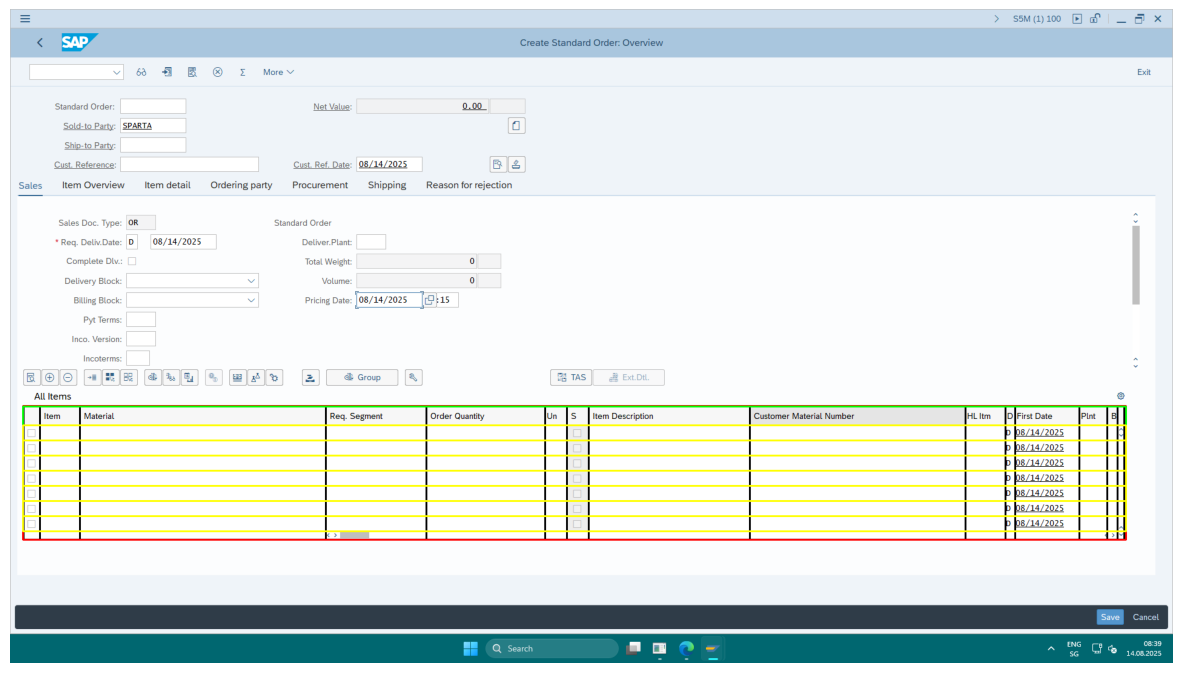

In [29]:
detect_sap_table("SAP.png", "prototype_SAP.png")